In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.filterwarnings("ignore")
import json

from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re

import requests

In [2]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

В этом блокноте будут лежать эксперименты с моделями и данными. Для начала, посмотрим, сможем ли улучшить качество, сгенерировав больше фичей.

In [3]:
data_rare = pd.read_csv('data_rare.csv', index_col=[0])

In [4]:
data_rare.loc[~data_rare['handshake'].isna(), 'is_handshake'] = 1
data_rare.loc[data_rare['is_handshake'].isna(), 'is_handshake'] = 0

In [5]:
fingerprint = []
alert_message = []
certificate = []
is_selfsigned = []

for i in range(0, len(data_rare)):
    fingerprint.append(len(re.findall('fingerprint', data_rare['handshake'].fillna('0')[i], flags=0)))
    alert_message.append(len(re.findall('alert_message', data_rare['packets'].fillna('0')[i], flags=0)))
    certificate.append(len(re.findall('certificate', data_rare['handshake'].fillna('0')[i], flags=0)))
    is_selfsigned.append(len(re.findall("'is_selfsigned': True", data_rare['handshake'].fillna('0')[i], flags=0)))

data_rare['fingerprint'] = fingerprint
data_rare['alert_message'] = alert_message
data_rare['certificate'] = certificate
data_rare['is_selfsigned'] = is_selfsigned

In [6]:
df = data_rare.drop(['index', 'packets', 'handshake', 'timestamps'], axis = 1)
df['country'] = pd.read_csv('data.csv')['country']

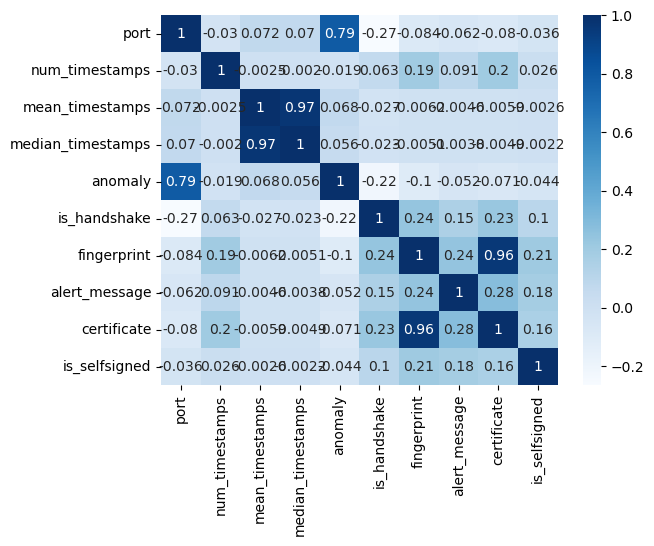

In [7]:
sns.heatmap(df[['addr', 'port', 'proto',
               'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly',
               'is_handshake', 'fingerprint', 'alert_message', 'certificate', 'is_selfsigned']].drop_duplicates().corr(), 
            cmap="Blues", annot=True);

# Подготовим данные:

1. Удалим скоррелированные колонки
2. Сделаем undersample для трейна
3. Скалируем

In [8]:
df = df.drop(['mean_timestamps', 'certificate', 'fingerprint'], axis = 1).drop_duplicates()

In [9]:
X = df[['addr', 'proto', 'num_timestamps', 
    'median_timestamps', 'anomaly', 'country', 'is_handshake',
       'alert_message', 'is_selfsigned']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']

In [10]:
X.anomaly.nunique()

2

In [11]:
X.shape

(17459, 9)

In [12]:
X['addr_1'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_1']

X['addr_2'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_2']

In [13]:
X.anomaly.nunique()

2

In [14]:
X.shape

(17459, 11)

In [15]:
X_new = X.drop(['proto', 'country', 'addr_1', 'addr_2'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

In [16]:
X_new.anomaly.nunique()

2

In [17]:
y = X_new['anomaly']
X = X_new.drop(['anomaly', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [20]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')

X_under, y_under = undersample.fit_resample(Xtrain, ytrain)

In [166]:
Xtrain.shape

(12221, 483)

In [171]:
ytrain.value_counts()

0    11905
1      316
Name: anomaly, dtype: int64

In [167]:
X_under.shape

(632, 483)

In [170]:
y_under.value_counts()

0    316
1    316
Name: anomaly, dtype: int64

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_under)

In [24]:
X_under = scaler.transform(X_under)

In [25]:
Xtest = scaler.transform(Xtest)

In [26]:
from sklearn.metrics import make_scorer, fbeta_score

score = make_scorer(fbeta_score, beta=1.5)

In [27]:
# для проверки
def fbeta(beta, y, preds):
    d = pd.DataFrame(y, columns = ['y'])
    d['pr'] = preds
    TP = len(d[(d['y'] == 1) & (d['pr'] == 1)])
    TP_FP = len(d[(d['y'] == 1) & (d['pr'] == 1)]) + len(d[(d['y'] == 0) & (d['pr'] == 1)])
    TP_FN = len(d[(d['y'] == 1) & (d['pr'] == 1)]) + len(d[(d['y'] == 0) & (d['pr'] == 1)])
    precision = TP / TP_FP
    recall = TP / TP_FN
    return ((1 + beta*beta) * precision * recall) / (beta*beta*precision + recall)

В первую очередь возьмем катбуст из ноутбука с EDA и переберем параметры для улучшения качества.

# Итерация 1

In [28]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

params = {'depth': [None, 1, 5, 10],
          'learning_rate' : [None, 0.05, 0.1, 0.5],
          'iterations'    : [None, 100, 200]
         }

ctb = CatBoostClassifier(random_state=42, verbose=False)

ctb_model = GridSearchCV(ctb, params, scoring=score, return_train_score=True, verbose=1.1)
ctb_model.fit(X_under, y_under)
print(ctb_model.best_params_)
print(ctb_model.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ....depth=None, iterations=None, learning_rate=None; total time=   3.2s
[CV] END ....depth=None, iterations=None, learning_rate=None; total time=   3.6s
[CV] END ....depth=None, iterations=None, learning_rate=None; total time=   3.1s
[CV] END ....depth=None, iterations=None, learning_rate=None; total time=   3.3s
[CV] END ....depth=None, iterations=None, learning_rate=None; total time=   3.6s
[CV] END ....depth=None, iterations=None, learning_rate=0.05; total time=   3.1s
[CV] END ....depth=None, iterations=None, learning_rate=0.05; total time=   3.1s
[CV] END ....depth=None, iterations=None, learning_rate=0.05; total time=   3.5s
[CV] END ....depth=None, iterations=None, learning_rate=0.05; total time=   3.1s
[CV] END ....depth=None, iterations=None, learning_rate=0.05; total time=   3.4s
[CV] END .....depth=None, iterations=None, learning_rate=0.1; total time=   3.1s
[CV] END .....depth=None, iterations=None, lear

[CV] END ........depth=1, iterations=200, learning_rate=None; total time=   0.5s
[CV] END ........depth=1, iterations=200, learning_rate=None; total time=   0.3s
[CV] END ........depth=1, iterations=200, learning_rate=None; total time=   0.4s
[CV] END ........depth=1, iterations=200, learning_rate=None; total time=   0.4s
[CV] END ........depth=1, iterations=200, learning_rate=0.05; total time=   0.4s
[CV] END ........depth=1, iterations=200, learning_rate=0.05; total time=   0.4s
[CV] END ........depth=1, iterations=200, learning_rate=0.05; total time=   0.3s
[CV] END ........depth=1, iterations=200, learning_rate=0.05; total time=   0.4s
[CV] END ........depth=1, iterations=200, learning_rate=0.05; total time=   0.3s
[CV] END .........depth=1, iterations=200, learning_rate=0.1; total time=   0.4s
[CV] END .........depth=1, iterations=200, learning_rate=0.1; total time=   0.4s
[CV] END .........depth=1, iterations=200, learning_rate=0.1; total time=   0.4s
[CV] END .........depth=1, i

[CV] END .......depth=10, iterations=100, learning_rate=None; total time=   1.3s
[CV] END .......depth=10, iterations=100, learning_rate=None; total time=   1.4s
[CV] END .......depth=10, iterations=100, learning_rate=0.05; total time=   1.4s
[CV] END .......depth=10, iterations=100, learning_rate=0.05; total time=   1.3s
[CV] END .......depth=10, iterations=100, learning_rate=0.05; total time=   1.3s
[CV] END .......depth=10, iterations=100, learning_rate=0.05; total time=   1.2s
[CV] END .......depth=10, iterations=100, learning_rate=0.05; total time=   1.3s
[CV] END ........depth=10, iterations=100, learning_rate=0.1; total time=   1.3s
[CV] END ........depth=10, iterations=100, learning_rate=0.1; total time=   1.3s
[CV] END ........depth=10, iterations=100, learning_rate=0.1; total time=   1.3s
[CV] END ........depth=10, iterations=100, learning_rate=0.1; total time=   1.2s
[CV] END ........depth=10, iterations=100, learning_rate=0.1; total time=   1.3s
[CV] END ........depth=10, i

KeyError: 'iterations'

In [29]:
print(ctb_model.best_params_)
print(ctb_model.best_score_)

{'depth': 1, 'iterations': None, 'learning_rate': 0.5}
0.9534834133168172


In [30]:
clf = CatBoostClassifier(random_state=42, verbose=False,
                        depth= 1, iterations= None, learning_rate= 0.5)

In [32]:
model_ctb = clf.fit(X_under, y_under)

In [33]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_ctb.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ctb.predict(Xtest)), 2)}")

roc_auc_score на трейне: 1.0
roc_auc_score на тесте: 0.94


In [34]:
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_ctb.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ctb.predict(Xtest), beta=1.5), 2)}")

f1_score на трейне: 1.0
f1_score на тесте: 0.42


In [36]:
fbeta(1.5, list(y_under), list(model_ctb.predict(X_under)))

0.9905956112852665

In [46]:
fbeta(1.5, list(ytest), list(model_ctb.predict(Xtest)))

0.18135376756066413

In [38]:
# сильно переобучилась под трейн

model AUC score: 0.937107535321821


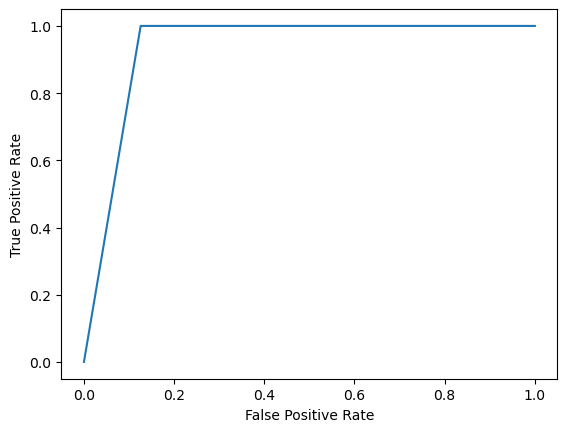

In [39]:
plot_roc_curve(ytest, model_ctb.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model_ctb.predict(Xtest))}')

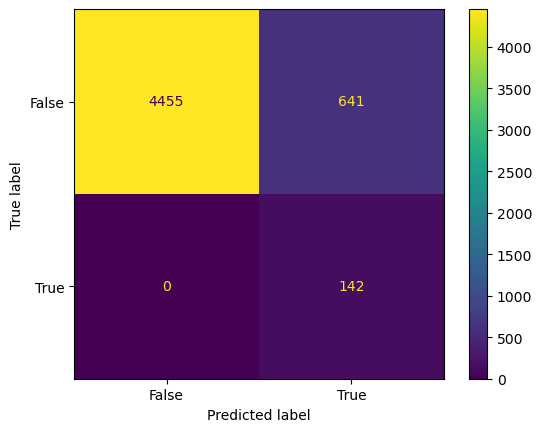

In [40]:
confusion_matrix = confusion_matrix(ytest, model_ctb.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()
# не ошибается на определении аноималии

In [41]:
feat = pd.DataFrame(model_ctb.feature_importances_,
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)

In [42]:
feat = feat.sort_values('coefs', ascending=False).head(20)

<function matplotlib.pyplot.show(close=None, block=None)>

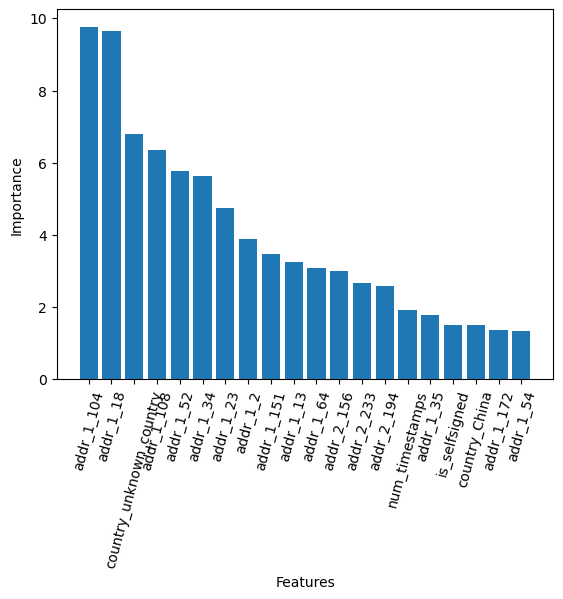

In [43]:
plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [21]:
import pickle
pickle.dump(model, open('ctb_model.pkl', 'wb'))

In [22]:
import joblib

joblib.dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# Итерация 2

max_depth поставить меньше

In [44]:
from sklearn.ensemble import RandomForestClassifier

params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 4, 5],
    'criterion' :['gini', 'entropy']
    }
rfc = RandomForestClassifier(random_state=42)

rfc_model = GridSearchCV(rfc, params, scoring=score)
rfc_model.fit(X_under, y_under)
print(rfc_model.best_params_)
print(rfc_model.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}
0.9386029166937806


In [47]:
clf = RandomForestClassifier(random_state=42, criterion = 'entropy',
                            max_depth= 4, max_features = 'log2', n_estimators = 500)

In [48]:
model_rfc = clf.fit(X_under, y_under)

In [49]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_rfc.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_rfc.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.92
roc_auc_score на тесте: 0.87


In [50]:
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_rfc.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_rfc.predict(Xtest), beta=1.5), 2)}")

f1_score на трейне: 0.95
f1_score на тесте: 0.26


In [51]:
fbeta(1.5, list(y_under), list(model_rfc.predict(X_under)))

0.8633879781420764

In [52]:
fbeta(1.5, list(ytest), list(model_rfc.predict(Xtest)))

0.09699453551912568

In [84]:
# сильно переобучилась

# Итерация 3

In [53]:
from sklearn.linear_model import LogisticRegression

params = {"penalty":["none","l2","l1"]}

lr = LogisticRegression(random_state=42)

lr_model = GridSearchCV(lr, params, scoring=score)
lr_model.fit(X_under, y_under)
print(lr_model.best_params_)
print(lr_model.best_score_)

{'penalty': 'l2'}
0.9476522748739242


In [54]:
clf = LogisticRegression(random_state=42, penalty= 'l2')
model_lr = clf.fit(X_under, y_under)

In [55]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_lr.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_lr.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_lr.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_lr.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 1.0
roc_auc_score на тесте: 0.96
f1_score на трейне: 1.0
f1_score на тесте: 0.54


In [56]:
# здесь куда лучше результат

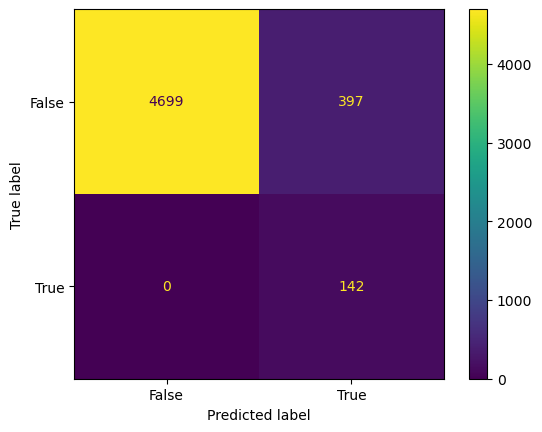

In [57]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


confusion_matrix = confusion_matrix(ytest, model_lr.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

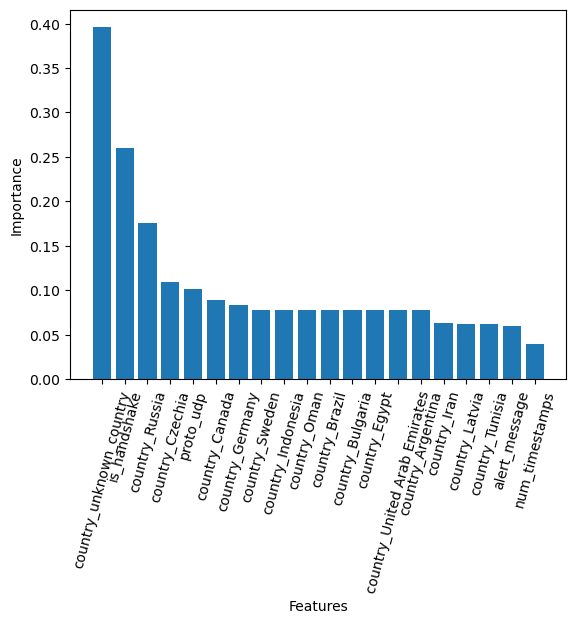

In [58]:
feat = pd.DataFrame(model_lr.coef_[0],
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)
feat = feat.sort_values('coefs', ascending=False).head(20)

plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [59]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_lr.predict(Xtest)

In [60]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# 0 процента выбросов не задетектировали

0.0

In [61]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и 7 процентов нормальных соединений

0.07790423861852433

In [62]:
len(C[(C['real']==1)])

142

# Итерация 4: несколько моделей из pyod

In [63]:
from pyod.models.inne import INNE

params = {'n_estimators': [50,100,200,500]}

inn = INNE(random_state=42)

inn_model = GridSearchCV(inn, params, scoring=score)
inn_model.fit(X_under, y_under)
print(inn_model.best_params_)
print(inn_model.best_score_)

{'n_estimators': 100}
0.04543371753366586


In [64]:
clf = INNE(random_state=42, n_estimators = 100)
model_inn = clf.fit(X_under, y_under)

In [65]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_inn.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_inn.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_inn.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(Xtest, model_inn.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.43
roc_auc_score на тесте: 0.43
f1_score на трейне: 0.04
f1_score на тесте: 0.01


In [73]:
# здесь совсем слабо
# Возможно, нормальная модель, но надо наоборот развернуть значения

In [70]:
pr = list(model_inn.predict(Xtest))
pr[pr.index(1)] = 3
pr[pr.index(0)] = 1
pr[pr.index(3)] = 0

fbeta_score(ytest, pr, beta=1.5)
# кажется, развернуть значения не сработало

0.0058956916099773245

In [71]:
from pyod.models.cblof import CBLOF

params = {'n_clusters': [5,10,50,100]
         }

cblof = CBLOF(random_state=42)

cblof_model = GridSearchCV(cblof, params, scoring=score)
cblof_model.fit(X_under, y_under)
print(cblof_model.best_params_)
print(cblof_model.best_score_)

{'n_clusters': 100}
0.012341772151898736


In [72]:
clf = CBLOF(random_state=42, n_clusters = 100)
model_cblof = clf.fit(X_under, y_under)

In [73]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_cblof.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_cblof.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_cblof.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_cblof.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.4
roc_auc_score на тесте: 0.43
f1_score на трейне: 0.0
f1_score на тесте: 0.0


In [74]:
pr = list(model_cblof.predict(Xtest))

In [75]:
pr[pr.index(1)] = 3
pr[pr.index(0)] = 1
pr[pr.index(3)] = 0

In [76]:
fbeta_score(ytest, pr, beta=1.5)
# кажется, развернуть значения не сработало

0.0

In [77]:
from pyod.models.dif import DIF

params = {'batch_size': [8,256,1000]
         }
dif = DIF(random_state=42)

dif_model = GridSearchCV(dif, params, scoring=score)
dif_model.fit(X_under, y_under)
print(dif_model.best_params_)
print(dif_model.best_score_)

{'batch_size': 8}
0.06133364650536673


In [79]:
clf = DIF(random_state=42, batch_size = 8)
model_dif = clf.fit(X_under, y_under)

In [80]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_dif.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_dif.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_dif.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_dif.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.5
roc_auc_score на тесте: 0.5
f1_score на трейне: 0.0
f1_score на тесте: 0.0


In [81]:
from pyod.models.ocsvm import OCSVM

params = {'kernel': ['poly', 'rbf', 'sigmoid']
         }
ocsvm = OCSVM()

ocsvm_model = GridSearchCV(ocsvm, params, scoring=score)
ocsvm_model.fit(X_under, y_under)
print(ocsvm_model.best_params_)
print(ocsvm_model.best_score_)

{'kernel': 'poly'}
0.21204620754236


In [82]:
clf = OCSVM(kernel= 'poly')
model_ocsvm = clf.fit(X_under, y_under)

In [83]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_ocsvm.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ocsvm.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_ocsvm.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ocsvm.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.6
roc_auc_score на тесте: 0.57
f1_score на трейне: 0.26
f1_score на тесте: 0.16


In [84]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'max_depth': [3, 10, 50],
          'learning_rate' : [0.01,0.1,0.5],
          'n_estimators': [20, 100, 200]
         }
gbc = GradientBoostingClassifier(random_state=42)

gbc_model = GridSearchCV(gbc, params, scoring=score, verbose=2.1)
gbc_model.fit(X_under, y_under)
print(gbc_model.best_params_)
print(gbc_model.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.820 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.788 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.813 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.840 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.823 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.891 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.822 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.876 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.872 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.901 to

[CV 1/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.940 total time=   2.3s
[CV 2/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.922 total time=   2.4s
[CV 3/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.976 total time=   2.5s
[CV 4/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.932 total time=   2.6s
[CV 5/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.936 total time=   2.4s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.945 total time=   0.0s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.941 total time=   0.0s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.967 total time=   0.0s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.919 total time=   0.0s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.956 total time=   0.0s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_est

In [85]:
clf = GradientBoostingClassifier(random_state=42, max_depth = 3, 
                                learning_rate = 0.5, n_estimators = 200)
model_gbc = clf.fit(X_under, y_under)

In [86]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, model_gbc.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_gbc.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_under, model_gbc.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_gbc.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 1.0
roc_auc_score на тесте: 0.94
f1_score на трейне: 1.0
f1_score на тесте: 0.43


In [87]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_gbc.predict(Xtest)

In [88]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# меньше одного процента выбросов

0.0

In [90]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# 12 процентов нормальных соединений

0.12205651491365777

Итого, лучше всего себя проявила логистическая регрессия, градиентный бустинг и катбуст. Попробуем чуть улучшить логистическую регессию и построить над ней бэггинг.

In [91]:
from sklearn.ensemble import BaggingClassifier

lr = LogisticRegression(random_state=42, penalty= 'l2')
bc = BaggingClassifier(lr)
bag = bc.fit(X_under, y_under)
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_under, bag.predict(X_under)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, bag.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_under, bag.predict(X_under), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, bag.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.98
roc_auc_score на тесте: 0.92
f1_score на трейне: 0.99
f1_score на тесте: 0.36


In [92]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = bag.predict(Xtest)

In [93]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# меньше 1 процента процента выбросов не задетектировали

0.0

In [95]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# 16 процентов нормальных соединений

0.16326530612244897

Посмотрим на процент ошибочных решений моделей

In [159]:
models_list = [model_ctb, model_rfc, model_lr, model_inn, model_cblof, model_dif, model_ocsvm, model_gbc, bag]

In [160]:
perc_anomaly = []
perc_usual = []

for i in models_list:
    C = pd.DataFrame(list(ytest), columns=['real'])
    C['preds'] = i.predict(Xtest)
    perc_anomaly.append(len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)]))
    perc_usual.append(len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)]))

In [162]:
models_names = ['model_ctb', 'model_rfc', 'model_lr', 'model_inn', 'model_cblof', 'model_dif', 'model_ocsvm', 'model_gbc', 'bag']
mistakes_df = pd.DataFrame(index = models_names, columns = ['perc_anomaly', 'perc_usual'])
mistakes_df['perc_anomaly'] = perc_anomaly
mistakes_df['perc_usual'] = perc_usual

In [163]:
mistakes_df

,perc_anomaly,perc_usual
model_ctb,0.000000,0.125785
model_rfc,0.000000,0.259419
model_lr,0.000000,0.077904
model_inn,0.985915,0.153257
model_cblof,1.000000,0.142465
model_dif,1.000000,0.000000
model_ocsvm,0.852113,0.015306
model_gbc,0.000000,0.122057
bag,0.000000,0.163265
